<a href="https://colab.research.google.com/github/chaos44/food_recognition/blob/master/food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)#2. Get the file
d10 = drive.CreateFile({'id':'1jqXr5d-UAhOUaPIb-g7p_8xEW9XxHjUr'}) # replace the id with id of file you want to access
d20 = drive.CreateFile({'id':'1hbZ19igWGti65MXOeGOwuzbSzVAOLdlH'})
d30 = drive.CreateFile({'id':'12uU6ocY9r6BfBk8fo4BQC8BVXjDDhCBb'})
d40 = drive.CreateFile({'id':'1Hs5OVtYD8xDvLd7y6drDHUu4ErXjBvr_'})
d50 = drive.CreateFile({'id':'19FaeD7fdFlqu0U8K2DIJevtp1tb4PbBe'})
d10.GetContentFile('d10.zip')
d20.GetContentFile('d20.zip')
d30.GetContentFile('d30.zip')
d40.GetContentFile('d40.zip')
d50.GetContentFile('d50.zip')

In [ ]:
!unzip d10.zip -d food
!unzip d20.zip -d food
!unzip d30.zip -d food
!unzip d40.zip -d food
!unzip d50.zip -d food

In [2]:
from PIL import Image
import os, glob
import numpy as np
from sklearn import model_selection
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# 中心から任意のサイズをトリミング
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [4]:
# パラメータの初期化
classes = ['beefdon', 'curry', 'fish', 'humberger', 'katsudon', 'ramen', 'seafooddon', 'soba', 'spaghetti', 'tempuradon'
         , 'udon', 'lasagna', 'hamburger_steak', 'nikujaga', 'fried_rice', 'omelette', 'sukiyaki', 'sushi', 'gyoza', 'fried_chicken'
         , 'okonomiyaki', 'croquette', 'pancake', 'french_toast', 'tart', 'taco_rice', 'doria', 'takoyaki', 'tapioca', 'yakisoba'
         , 'ginger_pork', 'steak', 'roast_meat', 'bread', 'yakitori', 'rice_ball', 'goya_chanpuru', 'instant_noodle', 'meat_bun', 'gratin'
         , 'mabo_tofu', 'tiramisu', 'cream_puff', 'eclair', 'hot_dog', 'potato_salad', 'stew', 'pizza', 'french_fry', 'avocado_salad']
num_classes = len(classes)
image_size = 150

In [5]:
# 画像の読み込みとnumpy配列への変換
X_train = [] # リスト
X_test = [] # リスト
y_train = [] # リスト
y_test = [] # リスト

In [6]:
# アスペクト比を固定して、幅が指定した値になるようリサイズする。
def scale_to_width(img, width):
    height = round(img.height * width / img.width)
    return img.resize((width, height))

In [8]:
for index, classlabel in enumerate(classes):
    photos_dir = './food/' + classlabel  
    files = glob.glob(photos_dir + '/*.jpg')
    count = len(files)
    # print(classlabel, count)  
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert('RGB')
        # image = image.convert('RGB')の前にトリミングするとメモリオーバー、理由不明
        # 食材ごとにテストとトレーニングに分ける
        # 画像サイズの取得
        # 長い方に沿ってトリミング
        # image = crop_center(image, 400, 400) # resizeする時にアスペクト比を固定させるため、400*400の部分をトリミング(800 * 800より正解率が上がる)
        w, h = image.size
        image = crop_center(image, w, w) if w >= h else crop_center(image, h, h)
        image = image.resize((image_size, image_size))
        data = np.asarray(image, dtype=np.float32) / 255.0  # 正規化 # dtype=np.float32でサイズ縮小、MemoryError解消のため # 2020/7/7
        if (i < 3/4 * count):
            X_train.append(data)
            y_train.append(index)
        else: 
            X_test.append(data)
            y_test.append(index)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [9]:
print(X_train.nbytes)
print(X_test.nbytes)
print(y_train.nbytes)
print(y_test.nbytes)

3431160000
1136700000
101664
33680


In [10]:
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y)
# X_train, X_test = model_selection.train_test_split(X)
# print(X_train.nbytes)
# print(X_test.nbytes)

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.applications import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [13]:
# compute quantities requiredXXfor featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [14]:
# mobile_net
#　モデルの定義
model_mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model_mobile_net.summary()
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model_vgg16.summary()
# print('Model loaded')
# model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
________________

In [16]:
# mobile_net
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:])) # 1番目は個数、その後の数を使う
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

model = Model(inputs=model.input, outputs=top_model(model.output))

# 最後のブロックだけ学習させる
for layer in model.layers[0:150]:
    layer.trainable = False

opt = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=100)

score = model.evaluate(X_test, y_test, batch_size=32)
print(score)

Epoch 1/100
398/397 [==============================] - 67s 167ms/step - loss: 3.1394 - accuracy: 0.2324
Epoch 2/100
398/397 [==============================] - 67s 168ms/step - loss: 2.2418 - accuracy: 0.4340
Epoch 3/100
398/397 [==============================] - 66s 166ms/step - loss: 1.9306 - accuracy: 0.5024
Epoch 4/100
398/397 [==============================] - 66s 166ms/step - loss: 1.7143 - accuracy: 0.5563
Epoch 5/100
398/397 [==============================] - 66s 165ms/step - loss: 1.5400 - accuracy: 0.5909
Epoch 6/100
398/397 [==============================] - 66s 167ms/step - loss: 1.4099 - accuracy: 0.6223
Epoch 7/100
398/397 [==============================] - 67s 167ms/step - loss: 1.3243 - accuracy: 0.6438
Epoch 8/100
398/397 [==============================] - 67s 167ms/step - loss: 1.2267 - accuracy: 0.6626
Epoch 9/100
398/397 [==============================] - 66s 166ms/step - loss: 1.1660 - accuracy: 0.6833
Epoch 10/100
398/397 [==============================] - 66s 166m

In [ ]:
#　モデルの定義
model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# print('Model loaded')
# model.summary()
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:])) # 1番目は個数、その後の数を使う
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

model = Model(inputs=model.input, outputs=top_model(model.output))

# model.summary()
for layer in model.layers[0:15]:
    layer.trainable = False

opt = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=100)

score = model.evaluate(X_test, y_test, batch_size=32)
print(score)

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/100
398/397 [==============================] - 67s 168ms/step - loss: 3.3209 - accuracy: 0.1624
Epoch 2/100
398/397 [==============================] - 67s 168ms/step - loss: 2.3771 - accuracy: 0.3784
Epoch 3/100
398/397 [==============================] - 67s 169ms/step - loss: 1.9105 - accuracy: 0.5016
Epoch 4/100
398/397 [==============================] - 68s 170ms/step - loss: 1.6124 - accuracy: 0.5761
Epoch 5/100
398/397 [==============================] - 68s 171ms/step - loss: 1.3801 - accuracy: 0.6297
Epoch 6/100
398/397 [==============================] - 68s 171ms/step - loss: 1.2117 - accuracy: 0.6762
Epoch 7/100
398/397 [==============================] - 67s 168ms/step - loss: 1.0661 - accuracy: 0.7142
Epoch 8/100
398/397 [==============================] - 67s 169ms/step - loss: 0.9283 - accuracy: 0.7433
Epoch 9/100
398/397 [==============================] - 68s 170ms/step - loss: 0.8369 - accuracy: 0.7713

In [ ]:
#　モデルの定義
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# opt = SGD(lr=0.01)
opt = Adam()

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.fit(X_train, y_train, batch_size=32, epochs=100)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=500)

score = model.evaluate(X_test, y_test, batch_size=32)

print(score)
# model.save('./food_recognition_cnn_50.h5')

Epoch 1/500
398/397 [==============================] - 63s 157ms/step - loss: 3.8246 - accuracy: 0.0546
Epoch 2/500
398/397 [==============================] - 61s 153ms/step - loss: 3.7309 - accuracy: 0.0680
Epoch 3/500
398/397 [==============================] - 60s 151ms/step - loss: 3.6171 - accuracy: 0.0863
Epoch 4/500
398/397 [==============================] - 60s 152ms/step - loss: 3.4912 - accuracy: 0.1091
Epoch 5/500
398/397 [==============================] - 60s 152ms/step - loss: 3.3987 - accuracy: 0.1259
Epoch 6/500
398/397 [==============================] - 60s 151ms/step - loss: 3.3327 - accuracy: 0.1372
Epoch 7/500
398/397 [==============================] - 60s 152ms/step - loss: 3.2535 - accuracy: 0.1542
Epoch 8/500
398/397 [==============================] - 60s 151ms/step - loss: 3.1511 - accuracy: 0.1810
Epoch 9/500
398/397 [==============================] - 60s 151ms/step - loss: 3.1050 - accuracy: 0.1859
Epoch 10/500
398/397 [==============================] - 60s 151m

In [ ]:
model.save('./food_recognition_cnn_50.h5')

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def process(data):
    plt.figure()
    plt.imshow(data)

In [ ]:
print(X_test.shape)

(4210, 150, 150, 3)


In [ ]:
# 比較用 800*800 トリミング
for index, classlabel in enumerate(classes):
    photos_dir = './food/' + classlabel  
    files = glob.glob(photos_dir + '/*.jpg')
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert('RGB')
        # image = image.convert('RGB')の前にトリミングするとメモリオーバー、理由不明
        image = crop_center(image, 800, 800) # resizeする時にアスペクト比を固定させるため、800*800の部分をトリミング
        image = image.resize((image_size, image_size))
        data = np.asarray(image, dtype=np.float32) / 255.0  # 正規化 # dtype=np.float32でサイズ縮小、MemoryError解消のため # 2020/7/7
        data = np.array(data)
        process(data)
        X = []
        # 最後尾に追加する
        X.append(data)
        X = np.array(X)
        result = model.predict([X])[0]
        # 値の大きい方の番号(配列の添字)を返す
        predicted = result.argmax()
        percentage = int(result[predicted] * 100)
        print(classes[predicted], percentage)
        print()
        if i > 0:
          break

beefdon 100

beefdon 99

curry 100

curry 100

fish 100

fish 99

humberger 100

humberger 100

ramen 99

ramen 99

seafooddon 99

seafooddon 100

soba 100

soba 100

spaghetti 99

spaghetti 98

tempuradon 99

tempuradon 99

udon 99

udon 99

lasagna 100



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


lasagna 99

hamburger_steak 100

hamburger_steak 99

nikujaga 99

nikujaga 99

fried_rice 97

fried_rice 100

omelette 100

omelette 99

sukiyaki 100

sukiyaki 99

sushi 99

sushi 99

gyoza 100

gyoza 100

fried_chicken 100

fried_chicken 100

okonomiyaki 99

okonomiyaki 99

croquette 100

croquette 99

pancake 100

pancake 100

french_toast 99

french_toast 99

tart 100

tart 98

taco_rice 99

taco_rice 99

doria 98

doria 99

takoyaki 69

takoyaki 100

tapioca 100

tapioca 100

yakisoba 100

yakisoba 99

ginger_pork 99

ginger_pork 99

steak 98

steak 99

roast_meat 99

roast_meat 99

bread 99

bread 99

yakitori 99

yakitori 99

rice_ball 100

rice_ball 99

goya_chanpuru 100

goya_chanpuru 99

instant_noodle 99

instant_noodle 99

meat_bun 100

meat_bun 100

gratin 99

gratin 99

goya_chanpuru 98

mabo_tofu 99

tiramisu 100

tiramisu 100

cream_puff 100

cream_puff 99

eclair 100

eclair 100

hot_dog 99

hot_dog 100

potato_salad 99

potato_salad 99

stew 100

stew 99

pizza 99

piz

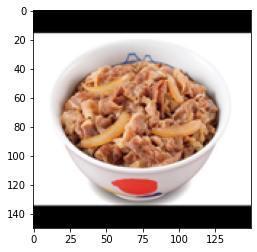

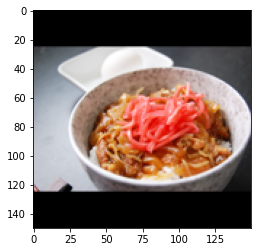

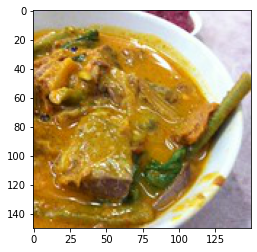

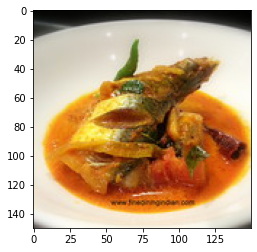

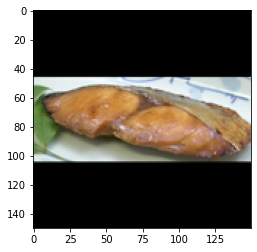

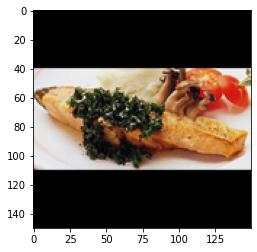

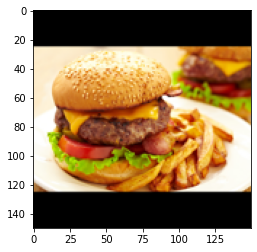

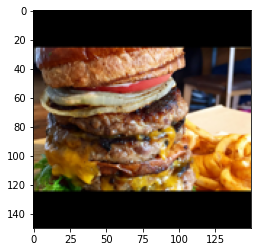

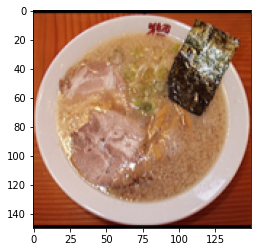

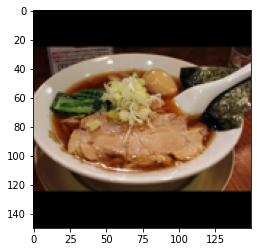

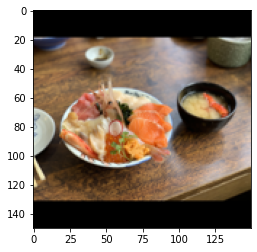

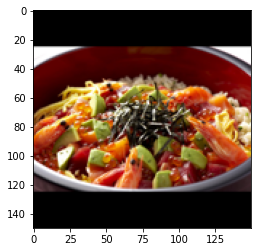

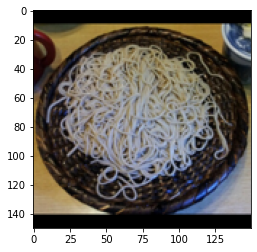

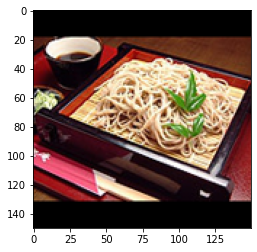

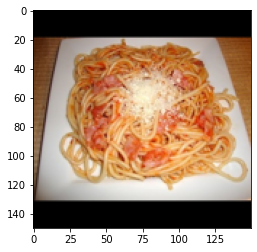

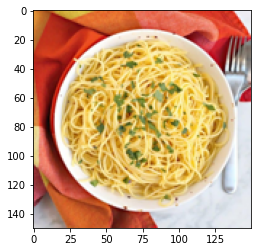

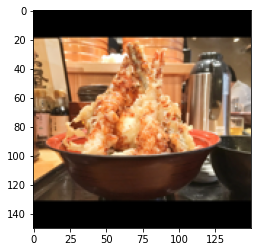

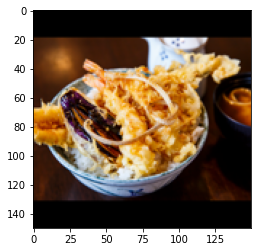

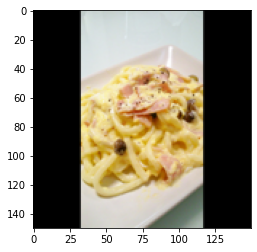

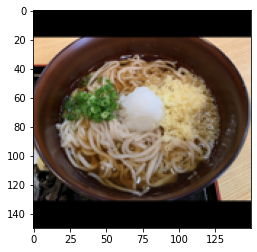

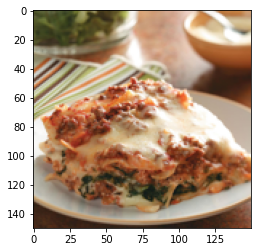

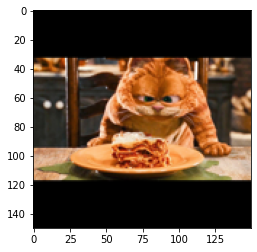

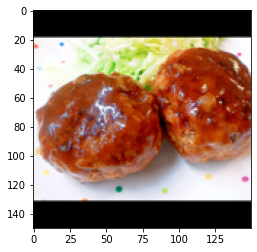

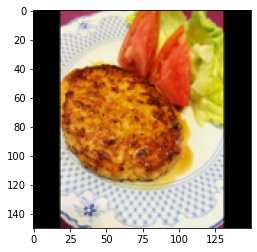

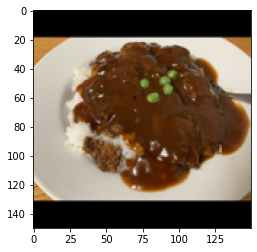

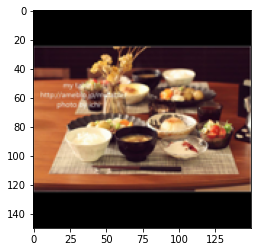

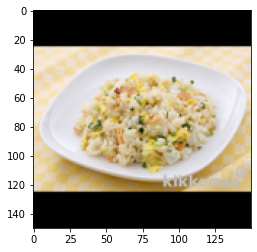

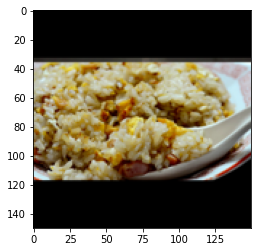

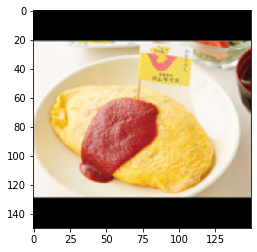

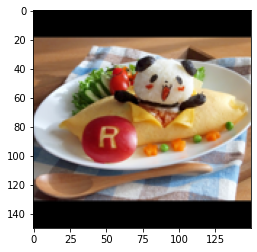

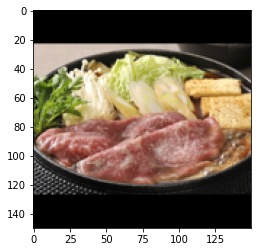

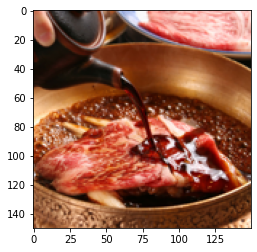

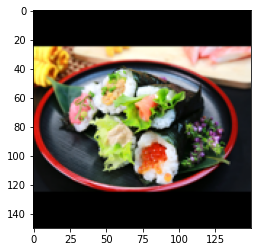

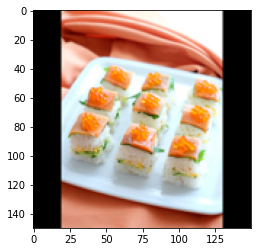

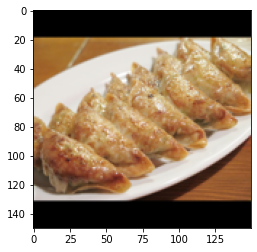

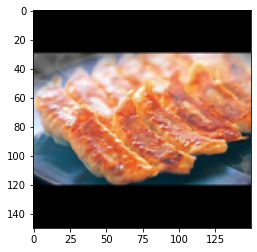

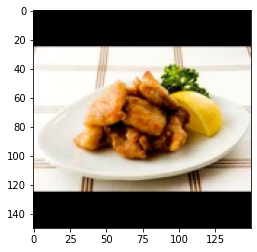

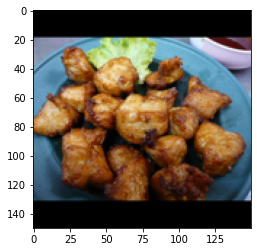

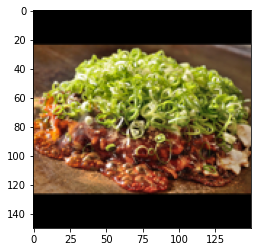

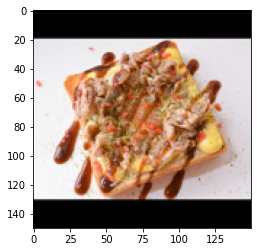

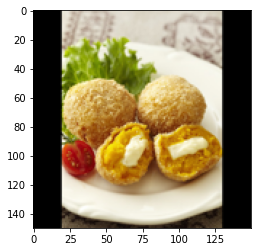

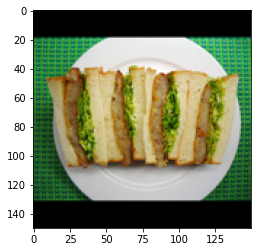

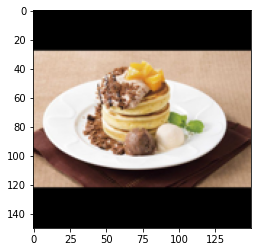

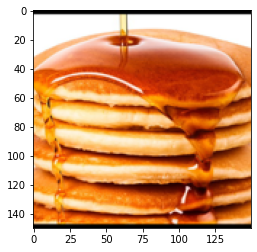

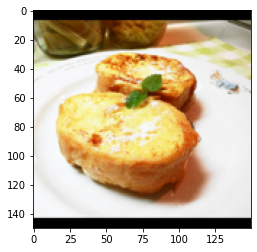

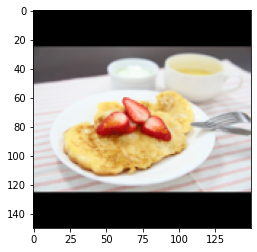

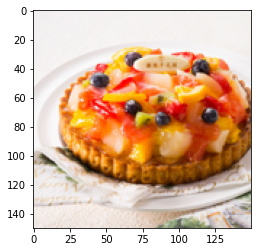

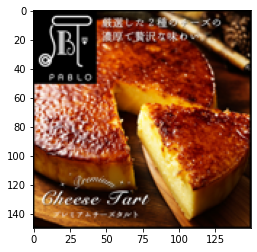

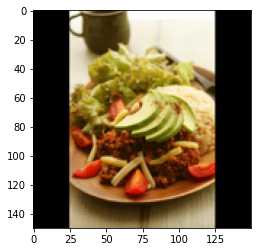

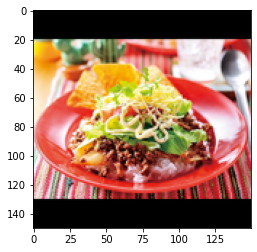

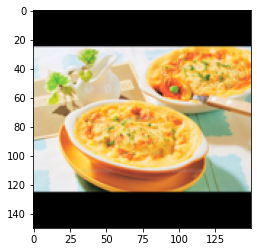

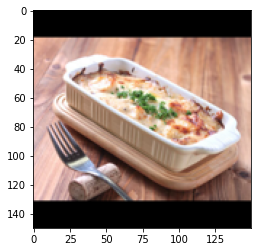

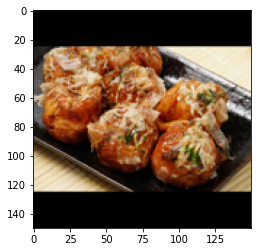

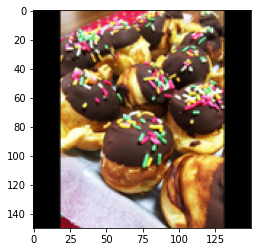

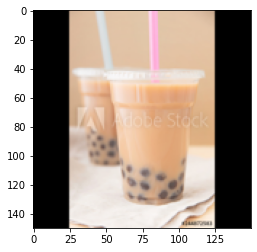

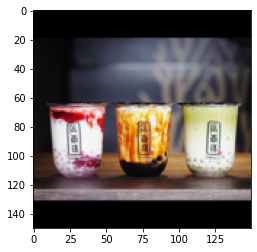

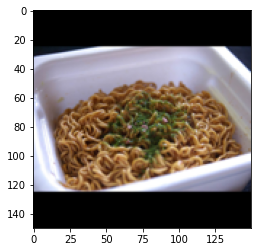

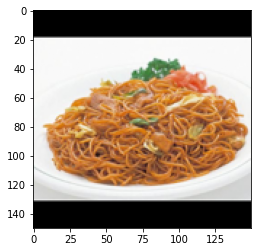

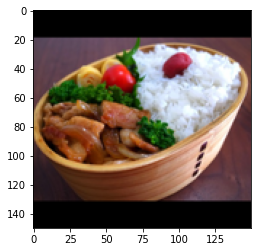

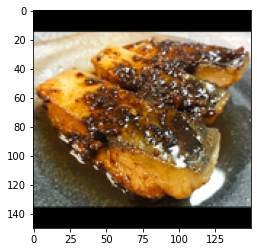

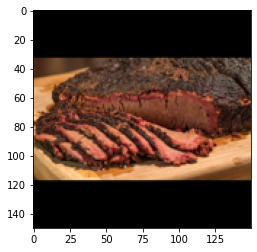

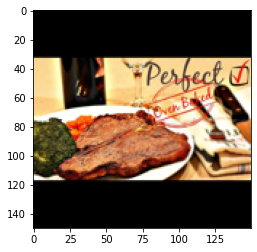

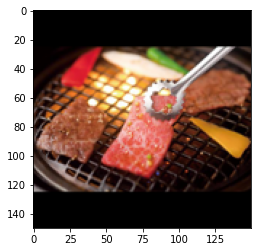

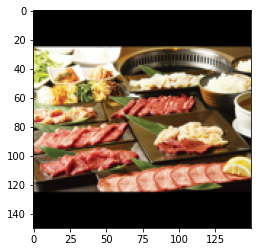

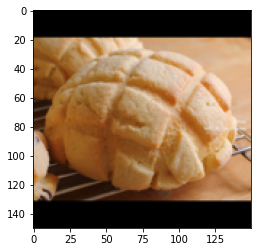

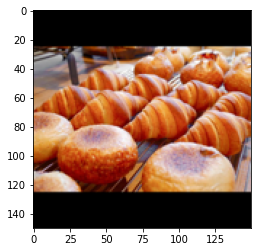

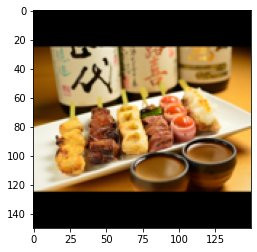

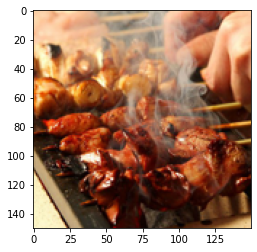

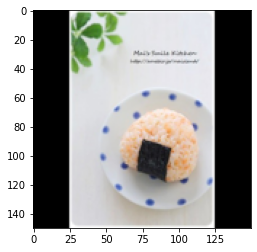

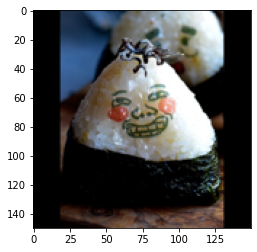

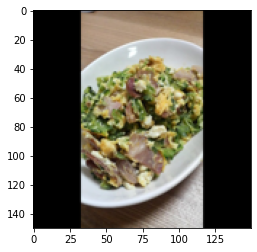

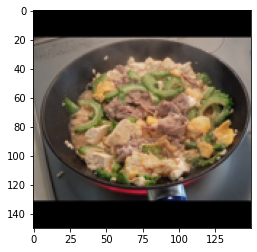

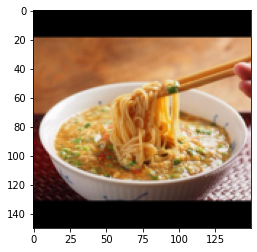

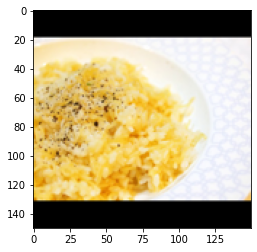

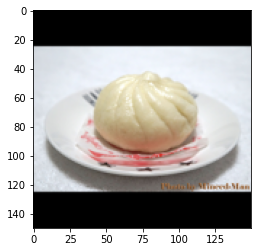

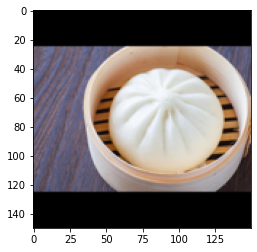

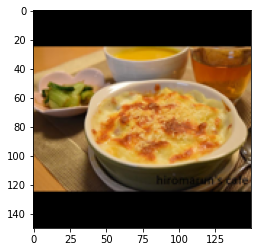

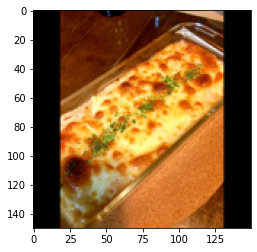

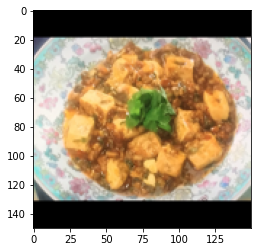

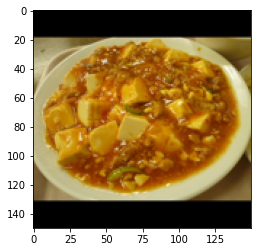

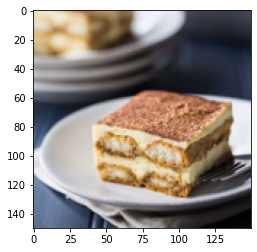

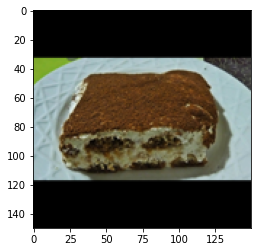

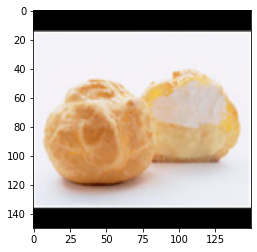

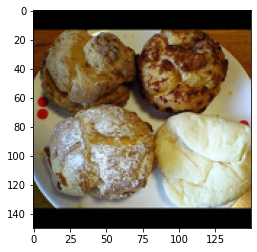

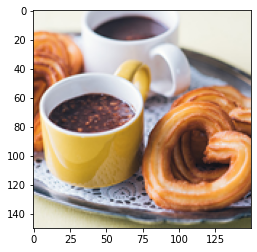

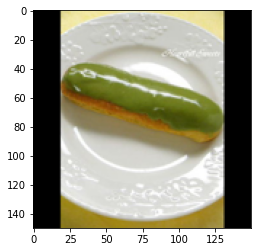

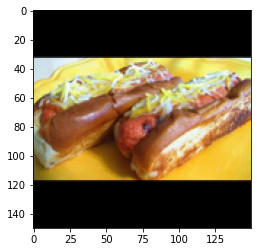

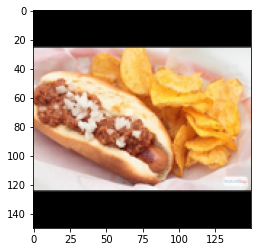

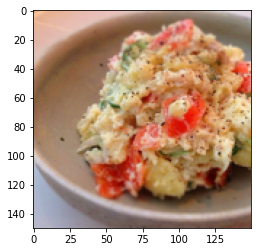

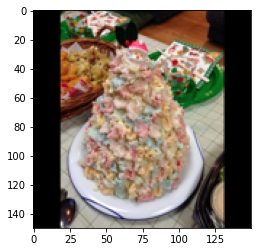

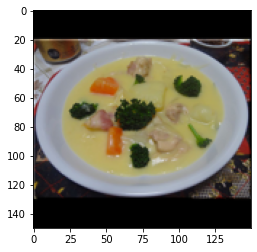

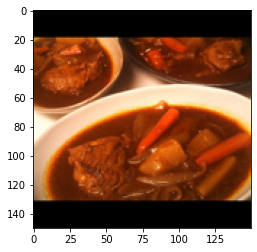

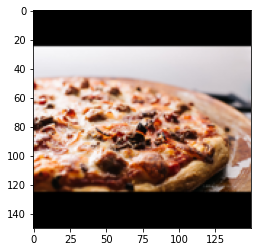

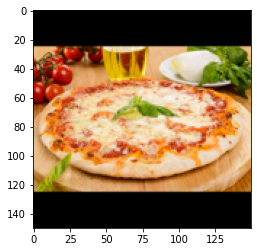

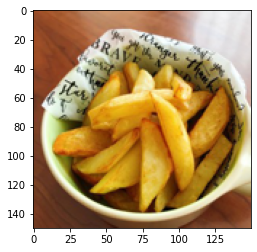

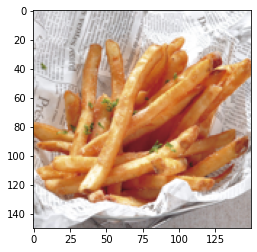

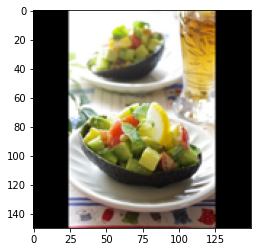

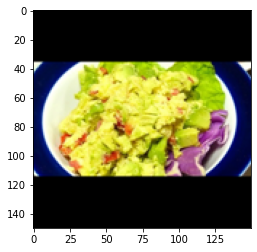

In [18]:
for index, classlabel in enumerate(classes):
    photos_dir = './food/' + classlabel  
    files = glob.glob(photos_dir + '/*.jpg')
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert('RGB')
        w, h = image.size
        image = crop_center(image, w, w) if w >= h else crop_center(image, h, h)
        image = image.resize((image_size, image_size))
        data = np.asarray(image, dtype=np.float32) / 255.0  # 正規化 # dtype=np.float32でサイズ縮小、MemoryError解消のため # 2020/7/7
        data = np.array(data)
        process(data)
        X = []
        # 最後尾に追加する
        X.append(data)
        X = np.array(X)
        result = model.predict([X])[0]
        # 値の大きい方の番号(配列の添字)を返す
        predicted = result.argmax()
        percentage = int(result[predicted] * 100)
        print(classes[predicted], percentage)
        print()
        if i > 0:
          break